In [169]:
#  Import some standard python modules
import os, json, time
from pyproj import Transformer, Geod
from wildfire.Reader import Reader as WFReader
import pandas as pd
import matplotlib.pyplot as plt

Set constants needed for this notebook

The following code block is taken from Dr. David McDonald except I added information about my own city, Murfreesboro, TN, to the CITY_LOCATIONS dictionary.

In [170]:
#
#    CONSTANTS
#

#
#    The 'Wildfire_short_sample_2024.json' is an extraction from the full 'USGS_Wildland_Fire_Combined_Dataset.json'
#    dataset extracting several major wildfires in California, plus a couple others that have interested data structure
#    features.
#
#    The sample file includes data for 15 fires, mostly oriented around the uniqueness of the name. Naming conventions
#    for wildfires is really adhoc, which makes finding any named fire in the dataset a disambiguation mess. The named
#    fires were selected from https://en.wikipedia.org/wiki/List_of_California_wildfires
#
#    The point nof the sample is to provide something small to test with before committing to processing the, much
#    larger, full dataset.
#
EXTRACT_FILENAME = "Wildfire_short_sample_2024.json"
#
#    The user module 'wildfire' contains a Reader object and the sample data. This bit of code finds where that is
#    located on your machine and constructs a path so that the sample data can be loaded. This assumes you have set
#    a PYTHONPATH environment variable to point to the location on your machine where you store python user modules.
#
#    NOTE: if you use Anaconda for virtual python environments, Anaconda will adhere to the PYTHONPATH conventions
#    for user modules.
#
MODULENAME = "wildfire"
MODULEPATH = ""
try:
    ppath = os.environ.get('PYTHONPATH')
    if not ppath: raise
    MODULEPATH = os.path.join(ppath,MODULENAME)
except:
    # Likely here because a PYTHONPATH was not set, show a warning message
    print("Looks like you're not using a 'PYTHONPATH' to specify the location of your python user modules.")
    print("You may have to modify the sample code in this notebook to get the documented behaviors.")
    MODULEPATH = ""

if MODULEPATH:
    SAMPLE_DATA_FILENAME = os.path.join(MODULEPATH,EXTRACT_FILENAME)
else:
    SAMPLE_DATA_FILENAME = EXTRACT_FILENAME
#
# print out where we think we're going to find the sample data
print(f"{SAMPLE_DATA_FILENAME=}")

#
#    A dictionary of some city locations from the US west coast states.
#
CITY_LOCATIONS = {
    'anchorage' :     {'city'   : 'Anchorage',
                       'latlon' : [61.2176, -149.8997] },
    'ocean_shores' :  {'city'   : 'Ocean Shores',
                       'latlon' : [47.0074, -124.1614] },
    'seaside' :       {'city'   : 'Seaside',
                       'latlon' : [45.9932, -123.9226] },
    'bend' :          {'city'   : 'Bend',
                       'latlon' : [44.0582, -121.3153] },
    'medford' :       {'city'   : 'Medford',
                       'latlon' : [42.3265, -122.8756] },
    'crescent_city' : {'city'   : 'Crescent City',
                       'latlon' : [41.7558, -124.2026] },
    'tomales' :       {'city'   : 'Tomales',
                       'latlon' : [38.2411, -122.9033] },
    'barstow' :       {'city'   : 'Barstow',
                       'latlon' : [34.8958, -117.0173] },
    'redding' :       {'city'   : 'Redding',
                       'latlon' : [40.5865, -122.3916] },
    'encinitas' :     {'city'   : 'Encinitas',
                       'latlon' : [33.0370, -117.2920] },
    'loveland' :      {'city'   : 'Loveland',
                       'latlon' : [40.398857, -105.052643] },
    'murfreesboro' :  {'city'   : 'murfreesboro',
                       'latlon' : [35.85, -86.42] }
}



Looks like you're not using a 'PYTHONPATH' to specify the location of your python user modules.
You may have to modify the sample code in this notebook to get the documented behaviors.
SAMPLE_DATA_FILENAME='Wildfire_short_sample_2024.json'


Define filepath to avoid using PYTHONPATH

In [171]:
SAMPLE_DATA_FILENAME = 'USGS_Wildland_Fire_Combined_Dataset.json'

Open Wildfire Reader Object

This code is taken from Dr. David McDonald

In [172]:
#
#    This bit of code opens a new wildfire reader, gets the header information and prints it to the screen
#
print(f"Attempting to open '{SAMPLE_DATA_FILENAME}' with wildfire.Reader() object")
wfreader = WFReader(SAMPLE_DATA_FILENAME)
print()
#
#    Now print the header - it contains some useful information
#
header_dict = wfreader.header()
header_keys = list(header_dict.keys())
print("The header has the following keys:")
print(header_keys)
print()
print("Header Dictionary")
print(json.dumps(header_dict,indent=4))


Attempting to open 'USGS_Wildland_Fire_Combined_Dataset.json' with wildfire.Reader() object

The header has the following keys:
['displayFieldName', 'fieldAliases', 'geometryType', 'spatialReference', 'fields']

Header Dictionary
{
    "displayFieldName": "",
    "fieldAliases": {
        "OBJECTID": "OBJECTID",
        "USGS_Assigned_ID": "USGS Assigned ID",
        "Assigned_Fire_Type": "Assigned Fire Type",
        "Fire_Year": "Fire Year",
        "Fire_Polygon_Tier": "Fire Polygon Tier",
        "Fire_Attribute_Tiers": "Fire Attribute Tiers",
        "GIS_Acres": "GIS_Acres",
        "GIS_Hectares": "GIS_Hectares",
        "Source_Datasets": "Source Datasets",
        "Listed_Fire_Types": "Listed Fire Types",
        "Listed_Fire_Names": "Listed Fire Names",
        "Listed_Fire_Codes": "Listed Fire Codes",
        "Listed_Fire_IDs": "Listed Fire IDs",
        "Listed_Fire_IRWIN_IDs": "Listed Fire IRWIN IDs",
        "Listed_Fire_Dates": "Listed Fire Dates",
        "Listed_Fire_C

Load all the wild fire data in

Function taken from Dr. David McDonald except I changed the MAX_FEATURE_LOAD to load all fires in at once

In [173]:
#
#    This sample code will load the whole sample (extracted data) file, or a small amount of the complete dataset.
#
MAX_FEATURE_LOAD = 135100
feature_list = list()
feature_count = 0
# A rewind() on the reader object makes sure we're at the start of the feature list
# This way, we can execute this cell multiple times and get the same result
wfreader.rewind()
# Now, read through each of the features, saving them as dictionaries into a list
feature = wfreader.next()
while feature:
    feature_list.append(feature)
    feature_count += 1
    # if we're loading a lot of features, print progress
    if (feature_count % 100) == 0:
        print(f"Loaded {feature_count} features")
    # loaded the max we're allowed then break
    if feature_count >= MAX_FEATURE_LOAD:
        break
    feature = wfreader.next()
#
#    Print the number of items (features) we think we loaded
print(f"Loaded a total of {feature_count} features")
#
#    Just a validation check - did all the items we loaded get into the list?
print(f"Variable 'feature_list' contains {len(feature_list)} features")




Loaded 100 features
Loaded 200 features
Loaded 300 features
Loaded 400 features
Loaded 500 features
Loaded 600 features
Loaded 700 features
Loaded 800 features
Loaded 900 features
Loaded 1000 features
Loaded 1100 features
Loaded 1200 features
Loaded 1300 features
Loaded 1400 features
Loaded 1500 features
Loaded 1600 features
Loaded 1700 features
Loaded 1800 features
Loaded 1900 features
Loaded 2000 features
Loaded 2100 features
Loaded 2200 features
Loaded 2300 features
Loaded 2400 features
Loaded 2500 features
Loaded 2600 features
Loaded 2700 features
Loaded 2800 features
Loaded 2900 features
Loaded 3000 features
Loaded 3100 features
Loaded 3200 features
Loaded 3300 features
Loaded 3400 features
Loaded 3500 features
Loaded 3600 features
Loaded 3700 features
Loaded 3800 features
Loaded 3900 features
Loaded 4000 features
Loaded 4100 features
Loaded 4200 features
Loaded 4300 features
Loaded 4400 features
Loaded 4500 features
Loaded 4600 features
Loaded 4700 features
Loaded 4800 features
L

Filter for fires between 1961 and 2021

In [181]:
# Create list for fire features that are within specified data range
valid_date_list = []

# Loop through all features in feature_list
for feature in feature_list:
    # Get fire year from feature
    fire_year = feature['attributes']['Fire_Year']

    # Check if the feature is within the specified year range and append to list
    if fire_year and 1961 <= fire_year <= 2021:
        valid_date_list.append(feature)

Function taken from Dr. David McDonald

In [175]:
#
#    Transform feature geometry data
#
#    The function takes one parameter, a list of ESRI:102008 coordinates that will be transformed to EPSG:4326
#    The function returns a list of coordinates in EPSG:4326
def convert_ring_to_epsg4326(ring_data=None):
    converted_ring = list()
    #
    # We use a pyproj transformer that converts from ESRI:102008 to EPSG:4326 to transform the list of coordinates
    to_epsg4326 = Transformer.from_crs("ESRI:102008","EPSG:4326")
    # We'll run through the list transforming each ESRI:102008 x,y coordinate into a decimal degree lat,lon
    for coord in ring_data:
        lat,lon = to_epsg4326.transform(coord[0],coord[1])
        new_coord = lat,lon
        converted_ring.append(new_coord)
    return converted_ring

Function created by Dr. David Mcdonald

In [176]:
#
#    The function takes two parameters
#        A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326
#        Ring_data - a list of decimal degree coordinates for the fire boundary
#
#    The function returns the average miles from boundary to the place
#
def average_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    # create a list to store our results
    distances_in_meters = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        distances_in_meters.append(d[2])
    #print("Got the following list:",distances_in_meters)
    # convert meters to miles
    distances_in_miles = [meters*0.00062137 for meters in distances_in_meters]
    # the esri polygon shape (the ring) requires that the first and last coordinates be identical to 'close the region
    # we remove one of them so that we don't bias our average by having two of the same point
    distances_in_miles_no_dup = distances_in_miles[1:]
    # now, average miles
    average = sum(distances_in_miles_no_dup)/len(distances_in_miles_no_dup)
    return average



Calculate distance for fires in the vlaid date range and save if within 1800 miles

In [204]:
# Prepare starting position
place = CITY_LOCATIONS["murfreesboro"]

# Get ring data for fire if available
def get_ring_data(wf_feature):
    if 'rings' in wf_feature['geometry']:
        return wf_feature['geometry']['rings'][0]
    elif 'curveRings' in wf_feature['geometry']:
        return wf_feature['geometry']['curveRings'][0]
    else:
        raise Exception("HEY! No compatible geometry in this fire data!!!")

# Initialize variables
distance_list = []
feature_count = 0
error_count = 0

# Process each wildfire feature with try except to handle errors
for wf_feature in valid_date_list:
    feature_count += 1

    try:
        # Attempt to get the ring data
        ring_data = get_ring_data(wf_feature)
        # Compute average distance from city ot fire perim using Dr.McDonald fucntion
        distance = average_distance_from_place_to_fire_perimeter(place['latlon'], ring_data)

        # Check if distance is <= 1800 miles and extract data for distance_list
        if distance <= 1800:
            distance_list.append({
                'year': wf_feature['attributes']['Fire_Year'],
                'size': wf_feature['attributes']['GIS_Acres'],
                'distance': distance
            })

    except Exception as e:
        error_count += 1
        print(f"Error processing feature {feature_count}: {e}")

    # Print progress every 100 features or at the end
    if feature_count % 100 == 0 or feature_count == len(valid_date_list):
        print(f"Processed {feature_count}/{len(valid_date_list)} features...")

# Final summary
print(f"Total features processed: {feature_count}")
print(f"Features within distance: {len(distance_list)}")
print(f"Total errors encountered: {error_count}")



Processed 100/118500 features...
Processed 200/118500 features...
Processed 300/118500 features...
Processed 400/118500 features...
Processed 500/118500 features...
Processed 600/118500 features...
Processed 700/118500 features...
Processed 800/118500 features...
Processed 900/118500 features...
Processed 1000/118500 features...
Processed 1100/118500 features...
Processed 1200/118500 features...
Processed 1300/118500 features...
Processed 1400/118500 features...
Processed 1500/118500 features...
Processed 1600/118500 features...
Processed 1700/118500 features...
Processed 1800/118500 features...
Processed 1900/118500 features...
Processed 2000/118500 features...
Processed 2100/118500 features...
Processed 2200/118500 features...
Processed 2300/118500 features...
Processed 2400/118500 features...
Processed 2500/118500 features...
Processed 2600/118500 features...
Processed 2700/118500 features...
Processed 2800/118500 features...
Processed 2900/118500 features...
Processed 3000/118500 f

In [205]:
# Convert distance_list to DataFrame
distance_df = pd.DataFrame(distance_list)

# Export distance_df to csv
distance_df.to_csv('distance_df.csv')

Calculate smoke impact estimates for fires within 650 miles of city

In [215]:
# Find fires within 650 miles
fires_distance_650 = distance_df[distance_df['distance'] <= 650]

In [217]:
# Calculate the smoke impact estimate for each fire
fires_distance_650['smoke_impact_estimate']= fires_distance_650['size'] / (fires_distance_650['distance'] + 1) **2

# Group by year and sum all estimates for eahc year
annual_smoke_impact = fires_distance_650.groupby('year').sum().reset_index()

C:\Users\holde\AppData\Local\Temp\ipykernel_29588\4042970434.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fires_distance_650['smoke_impact_estimate']= fires_distance_650['size'] / (fires_distance_650['distance'] + 1) **2


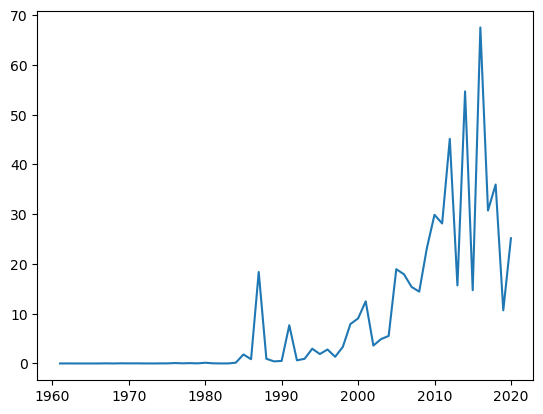

In [218]:
# Quick plot to see the trend of the smoke impact estimate
plt.plot(annual_smoke_impact['year'], annual_smoke_impact['smoke_impact_estimate'])

In [219]:
# Export annual smoke impact estimate to csv
annual_smoke_impact.to_csv('smoke_impact_fires_650miles.csv')